# Universal Language Model and Transfer Learning 

**General**

This notebook describes a process of text preocessing, where the weights of a pre-trained language model is used for another NLP task, document classification task in this case. The idea here is to create our own pre-trained language model, based on our own data, as opposed to the use of shelf products such as ELMo etc.

Naturally, a language model (a model that predicts the next word of a sentence), requires a huge data set for training in order for the model to able to "understand" the context of the preceding words/sentence. The size of the training set, 750K sentences 10 tokens each, is probably not enough for high accuracy, but for the sake of this exercise it did the work and produces ~40% accuracy.

Another point to note is the transfer model. On the classification task, instead of using the transfer model to completely reach the required class, I stopped one step earlier so that the model provides a representation vector per document that can be used for the classification prediction in another model (not necessarily a deep learning one). 

**Content**

**Phase 1** - Build a model that predicts the next word (Language Model)

**Phase 2** - Prepare the input for the classification prediction phase (transfer model)

**Phase 3** - Transfer model

### Imports

In [1]:
# Enable joblib at Floydhub cloud services
!pip install joblib

    100% |████████████████████████████████| 276kB 13.2MB/s 
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 2.2.3 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.2.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.1.0 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import nltk
import os, sys, re, collections, string
from operator import itemgetter as at
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact
#sys.path.append("../python")
import data3 as data # I made some modifications and saved it as data2
%matplotlib inline
from nltk.tokenize import wordpunct_tokenize, word_tokenize, casual_tokenize
from keras.utils import to_categorical
from keras.models import Model, load_model, Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Convolution1D
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate
from keras.layers import MaxPooling1D, MaxPooling2D
from keras.layers import Input
from keras.layers import LSTM, Conv1D, Bidirectional, GRU
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
import joblib

Using TensorFlow backend.


# Phase 1 - Build a model that predicts the next word 

### Get the train and test texts

Note that I made some modifications to some of the functions in 'data.py' file, therefore it is called 'data2.py' or 'data3.py' (these are the same).

One of the modifications is deliberately leaving the punctuation on, so that it will help the model to understand the context.

In [5]:
X_train, y_train = data.preprocessed()

100%|██████████| 4427/4427 [00:04<00:00, 1072.51it/s]


In [6]:
len_train = len(X_train)

In [7]:
X_train[0][:1000]

'##### \n\nexhibit <NUM>\n\nsecond amended and restated \n\n\n\nof \n\nruss berrie and company, inc. \n\nas of december <NUM>, <NUM> \n\n<NUM>\\. meetings of shareholders. \n\n<NUM> annual meeting. the annual meeting of shareholders shall be held on the third thursday of april in each year, or as soon thereafter as practicable as determined by the board. the annual meeting shall be held at a place and time determined by the board. \n\n<NUM> special meetings. special meetings of the shareholders may be called by resolution of the board or by the chairman of the board or the president and shall be called by the president or secretary upon the written request (stating the purpose or purposes of the meeting) of a majority of the board or of the holders of <NUM>% of the outstanding shares entitled to vote. \n\n<NUM> place of meetings. meetings of the shareholders may be held in or outside new jersey at the place and time specified by the board or the officer or shareholders requesting the m

In [8]:
len_train = len(X_train)

preprocesses_test() is a fuction I added to 'data.py'

In [9]:
X_test = data.preprocessed_test() # I added this function to get the processed text of the test data

100%|██████████| 822/822 [00:00<00:00, 1051.10it/s]


In [10]:
X_test[0][:1000]

'  \n\n\n\n\nthis employment agreement (the “agreement”) is made as of january <NUM>, <NUM> by and between cyclacel pharmaceuticals, inc. (the “company”), a delaware corporation, and paul mcbarron (the “executive”).\n\nwhereas, company desires to continue to retain the executive’s services as its executive vice president, finance, chief financial officer, chief operating officer and secretary; and \n\nwhereas, company and the executive are desirous of agreeing the terms and conditions of the executive’s employment with the company as set forth herein.\n\nnow, therefore, in consideration of the foregoing and the mutual covenants and conditions herein contained, the parties hereby agree as follows:\n\n<NUM>\\. employment. company hereby employs the executive and the executive accepts such employment according to the terms and conditions set forth in this agreement.\n\n<NUM>\\. term. except for earlier termination as hereinafter provided for, the term of the executive’s employment hereund

### Tokenizing

Using 'casual_tokenize' to maintain puntuztion and <>

In [11]:
tokenizing = " ".join(casual_tokenize(X_test[0]))

In [12]:
tokenizing[:1000]

'this employment agreement ( the “ agreement ” ) is made as of january <NUM> , <NUM> by and between cyclacel pharmaceuticals , inc . ( the “ company ” ) , a delaware corporation , and paul mcbarron ( the “ executive ” ) . whereas , company desires to continue to retain the executive ’ s services as its executive vice president , finance , chief financial officer , chief operating officer and secretary ; and whereas , company and the executive are desirous of agreeing the terms and conditions of the executive ’ s employment with the company as set forth herein . now , therefore , in consideration of the foregoing and the mutual covenants and conditions herein contained , the parties hereby agree as follows : <NUM> \\ . employment . company hereby employs the executive and the executive accepts such employment according to the terms and conditions set forth in this agreement . <NUM> \\ . term . except for earlier termination as hereinafter provided for , the term of the executive ’ s emp

In [13]:
X_train_tok = [" ".join(casual_tokenize(text)) for text in tqdm(X_train)]
X_test_tok = [" ".join(casual_tokenize(text)) for text in tqdm(X_test)]

Adding 'BOS' (beginning of sentense) since the sentenses are being concatenated later, so I need a separation between them.

In [14]:
X_train = ["<BOS> " + text for text in tqdm(X_train_tok)]
X_test = ["<BOS> " + text for text in tqdm(X_test_tok)]

In [15]:
X_train[0][:1000]

'<BOS> # # # exhibit <NUM> second amended and restated of russ berrie and company , inc . as of december <NUM> , <NUM> <NUM> \\ . meetings of shareholders . <NUM> annual meeting . the annual meeting of shareholders shall be held on the third thursday of april in each year , or as soon thereafter as practicable as determined by the board . the annual meeting shall be held at a place and time determined by the board . <NUM> special meetings . special meetings of the shareholders may be called by resolution of the board or by the chairman of the board or the president and shall be called by the president or secretary upon the written request ( stating the purpose or purposes of the meeting ) of a majority of the board or of the holders of <NUM> % of the outstanding shares entitled to vote . <NUM> place of meetings . meetings of the shareholders may be held in or outside new jersey at the place and time specified by the board or the officer or shareholders requesting the meeting . <NUM> no

### Create word_index and encoding

Methodically, using the tokens on the test set for learning is not a good practice, however the train and test sets for the language model are structured in another way, so that the data is split differently (will be elaborated later), so I allowed it here. However, leaving some part of the documents for validation should have been done.

In [2]:
# # Combining all documents
X = X_train + X_test

In [17]:
# Counting the number of words
word_count = collections.Counter()
for x in tqdm(X):
    word_count += collections.Counter(x.split())
total_word_count = sum(word_count.values())
word_count_hist = collections.Counter(word_count.values())
print ("Total word count: "+str(total_word_count))


Total word count: 20841737


The next cell allows determining the number of words to be used, based on the corpus coverage (how may tokens are covered out of the total) and vocabulary size. 

In [18]:
@interact(lb = (0,50), ub =(1000,2100000))
def vocab_coverage(lb=10,ub=1800000):
    lex_2 = [w for w in word_count if ub >= word_count[w] >= lb]
    words_covered = sum([wc*n for wc, n in word_count_hist.items() if lb<wc<ub])
    corpus_percentage = words_covered/total_word_count
    return "Corpus Coverage: {:.2f}%, lexicon used: {} words.".format(corpus_percentage*100, len(lex_2))

interactive(children=(IntSlider(value=10, description='lb', max=50), IntSlider(value=1800000, description='ub'…

I'll take out words that appear less than three times.

In [19]:
def create_word_index(lb, ub, counter):
    """
    The function creates a word index, where each token is designated with an index. This is used for encoding.
    input:
    - lb: lower bound, the minimum number that a word appears in the original korpus
    - ub: upper bound, the maximum number that a word appears in the original korpus
    - counter: a Counter object that contains the frequency of each word 
    The function returns a dictionary with the words as keys and the index as values 
    """
    
    lexicon_2 = [w for w in counter if ub >= counter[w] >= lb]
    print("New lexicon length: {}.".format(len(lexicon_2)))
    word_index = {}
    counter = 1
    for word in lexicon_2:
        word_index[word] = counter
        counter += 1
    return word_index

In [20]:
word_index = create_word_index(3, 18000000, word_count)

New lexicon length: 19692.


In [21]:
joblib.dump(word_index, 'word_index_19692')

['word_index_19692']

In [22]:
# I add +1 to make room for “0” which is “I don’t know” or “unknown”. Naturally the model will encounter unknown words
vocab_size = len(word_index)+1
vocab_size

19693

In [23]:
X_tokenized = [text.split() for text in X]
X_tokenized[0][:10]

['<BOS>',
 '#',
 '#',
 '#',
 'exhibit',
 '<NUM>',
 'second',
 'amended',
 'and',
 'restated']

In [24]:
# Encoding the tokenized sentences into numbers
X_encoded = [[word_index[token] if token in word_index else 0 for token in doc] for doc in X_tokenized]

In [25]:
X_encoded[77][:10]

[1, 2, 2, 2, 3, 4, 915, 2687, 465, 13]

In [26]:
len(X_encoded)

5249

In [47]:
joblib.dump(X_encoded, 'X_encoded')

['X_encoded']

### Preparing the input for the model

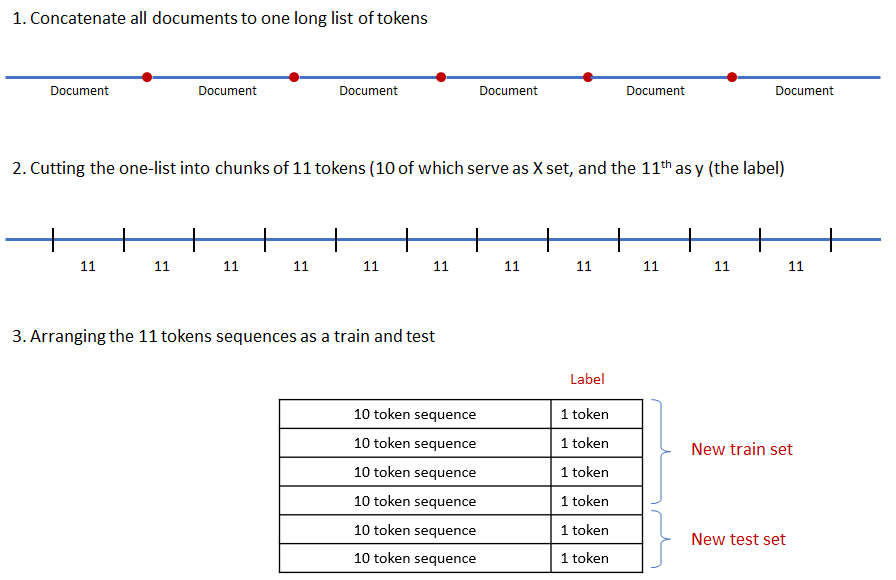

Ideally, one can get more data if the chunks are cut in a way that the next chunk is not after 11 tokens but after 1 or two tokens, so that there is an overlap between chunks. This way the data size can be ~20M samples and can produce better performance.

**Create a fixed-size matrix**

In [27]:
# Concatenating the documents to a long sequence of tokens
X_flat = [item for sublist in X_encoded for item in sublist]
len(X_flat)

20841737

In [28]:
# Cutting the long sequence into chunks of 11. Longer chunks provided lower performance
CHUNK_SIZE = 11
X_flat_array = np.array(X_flat)

In [29]:
def reshape_to_matrix(encoded_array, chunk_size):
    """
    Takes a flatten array of numbers, rounds it down to allow devision by the chunk_size, and reshaping it to a matrix with 
    n_rows rows and chunk_size columns.
    """
    # Calculate the number of rows
    n_rows = len(encoded_array) // chunk_size
    # Calculate the number of elements to truncate
    n_truncate = len(encoded_array) - n_rows*chunk_size
    truncated = encoded_array[:-n_truncate]
    # Reshape the array
    new_array = truncated.reshape(n_rows, chunk_size)
    return new_array

In [30]:
input_matrix = reshape_to_matrix(X_flat_array, CHUNK_SIZE)
input_matrix.shape

(1894703, 11)

At this point I have an array with 1894703 rows and 11 columns

In [31]:
# Taking a look at the fisrt two arrays
input_matrix[:2,:]

array([[ 1,  2,  2,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11,  7, 12, 13, 14, 15, 16,  9, 17,  4]])

In [32]:
# Now Shuffle it
np.random.shuffle(input_matrix)

In [33]:
# I am reducing the size of the data to get shorter training time and mempry requirement
REDUCTION_RATE = 0.4
data_size = int(len(input_matrix) * REDUCTION_RATE)
reduced_input_matrix = input_matrix[:data_size, :]
reduced_input_matrix.shape

(757881, 11)

**Generate X and y arrays and split to train and test sets**

In [34]:
X_set = reduced_input_matrix[:,:-1]
X_set.shape

(757881, 10)

In [35]:
y_set = reduced_input_matrix[:,-1]
y_set.shape

(757881,)

In [36]:
X_train_for_model, X_test_for_model, y_train, y_test = train_test_split(X_set, y_set, test_size=0.2, random_state=0)

In [37]:
joblib.dump(X_train_for_model, 'X_train_with_weights')
joblib.dump(y_train, 'y_train_with_weights')
joblib.dump(X_test_for_model, 'X_test_woth_weights')
joblib.dump(y_test, 'y_test_with_weights')

['y_test_with_weights']

In [34]:
# X_train_for_model = joblib.load('X_train_with_weights')
# y_train = joblib.load('y_train_with_weights')
# X_test_for_model = joblib.load('X_test_woth_weights')
# y_test = joblib.load('y_test_with_weights')

In [38]:
# Convert y_train to one-hot
y_train_cat = to_categorical(y_train, num_classes=19693)
y_train_cat.shape

(606304, 19693)

In [39]:
X_train_for_model.shape

(606304, 10)

In [40]:
# Convery y_test to one-hot
y_test_cat = to_categorical(y_test, num_classes=19693)
y_test_cat.shape

(151577, 19693)

In [41]:
X_test_for_model.shape

(151577, 10)

**Word Embedding**

Pre-trained embedding can be used. If used the next cells are available. Also the embedding layer in the model should be modified (also available and commented within the model)

In [3]:
# with open(r"/floyd/input/glove_embedding/glove.840B.300d.txt", "r", encoding="UTF-8") as f:
#     glove = f.readlines()

In [4]:

# # The file is a text file, where each line begins with a word, and then 300 float numbers separated by scace
# # The embedding matrix for the model requires a dictionary
# embedding_dict = {}
# for line in tqdm(glove):
#     split_line = line.split()
#     word = split_line[0]
#     # Turning the list of numbers to numpy array
#     vect = np.array(split_line[1:])
#     embedding_dict[word] = vect

In [5]:
# word_index = joblib.load('word_index_19692')

In [6]:
# # create a weight matrix for words in training docs
# embedding_matrix = np.zeros((19693, 300))
# for word, i in tqdm(word_index.items()):
#     if word in embedding_dict.keys():
#         # It turns out that some vectors are over 300 values and other do not contain numbers
#         try:
#             embedding_vector = embedding_dict[word][:300]
#             #print(len(embedding_vector))
#             #if embedding_vector is not None: # Only if exits in the pre-trained
#             embedding_matrix[i] = embedding_vector
#         except ValueError:
#             pass

## Build Model

In [42]:
def create_model(vocab, length): #  embedding_matrix
    inputs_shape = Input(shape=(length,))
    embed = Embedding(input_dim=vocab, output_dim=200,\
                      input_length=length)(inputs_shape) # output_dim=300, weights=[embedding_matrix],trainable=True,
    spat_drop = SpatialDropout1D(0.2)(embed)
    lstm = Bidirectional(LSTM(150, recurrent_dropout=0.35, return_sequences=True))(spat_drop)
    drop = Dropout(0.25)(lstm)
    pool = MaxPooling1D(pool_size=3)(drop)
    flat = Flatten()(pool)
    dense1 = Dense(1500, activation='relu')(flat)
    drop1 = Dropout(0.25)(dense1)
#     dense2 = Dense(1500, activation='relu')(drop1)
#     drop2 = Dropout(0.3)(dense2)
    output = Dense(vocab, activation='softmax')(drop1)
    model = Model(inputs=inputs_shape, outputs=output)
    # Compiling
    #epochs = 30
    learning_rate = 0.0002
    #decay_rate = learning_rate / epochs
    adam = optimizers.Adam(lr=learning_rate, decay=0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [43]:
# Create the model
model = create_model(vocab_size, CHUNK_SIZE-1)

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 200)           3938600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 10, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 300)           421200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 300)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
__________

In [45]:
BATCH_SIZE = 700
EPOCHS = 30

In [46]:
# Train the model
r = model.fit(X_train_for_model, y_train_cat, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test_for_model, y_test_cat), verbose=1)

Train on 606304 samples, validate on 151577 samples
Epoch 1/30
606304/606304 [==============================] - 298s 491us/step - loss: 5.8685 - acc: 0.0824 - val_loss: 5.3458 - val_acc: 0.1307
Epoch 2/30
606304/606304 [==============================] - 348s 574us/step - loss: 4.8913 - acc: 0.1828 - val_loss: 4.6094 - val_acc: 0.2178
Epoch 3/30
606304/606304 [==============================] - 334s 551us/step - loss: 4.4643 - acc: 0.2288 - val_loss: 4.3300 - val_acc: 0.2468
Epoch 4/30
606304/606304 [==============================] - 362s 598us/step - loss: 4.1989 - acc: 0.2545 - val_loss: 4.1081 - val_acc: 0.2697
Epoch 5/30
606304/606304 [==============================] - 350s 577us/step - loss: 3.9884 - acc: 0.2750 - val_loss: 3.9512 - val_acc: 0.2897
Epoch 6/30
606304/606304 [==============================] - 367s 605us/step - loss: 3.8157 - acc: 0.2915 - val_loss: 3.8199 - val_acc: 0.3045
Epoch 7/30
606304/606304 [==============================] - 376s 620us/step - loss: 3.6664 - acc

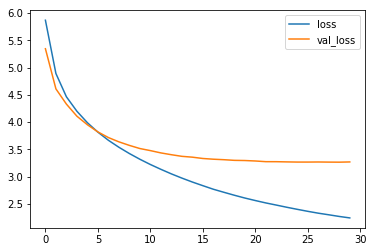

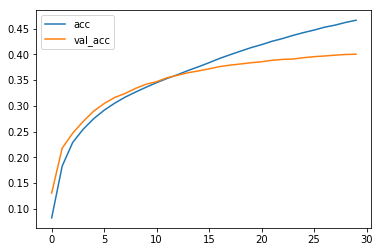

In [48]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [50]:
model.save('model_with_weights21')

In [30]:
# model = load_model('model_with_weights')

**Predicition**

In [28]:
# word_index = joblib.load('word_index_19692')

In [49]:
# Need the index to get the words back
index_to_word = {value:key for key, value in word_index.items()}

In [64]:
def predict_one_chunk(chunk, label, model, index_to_words):
    """ Function takes a chunks of indices and a label, and returns the original words and the predictions"""
    
    # First reshape to mach the correcet input
    reshaped = chunk.reshape((1,10))
    prediction = model.predict(reshaped)
    # Get the most probabalistic prediction
    first_pred_idx = prediction.argmax()
    first_pred = index_to_words[first_pred_idx]
    # Get the next 3 predtictions
    next_predictions_idx = prediction.argsort()[0][-4:-1][::-1]
    next_preds = [index_to_words[idx] for idx in next_predictions_idx]
    sent = [index_to_words[idx] for idx in chunk]
    label_word = index_to_words[label]
#     print("Sentence: ", sent)
#     print("Label: ", label_word)
#     print("Prediction: ", first_pred)
#     print("next_preds", next_preds)
    
    return first_pred

One can try the model by choosing an index and view the 10-token-sequence and the prediction, as well as the next 3 probable predictions. Just need to uncomment the prints in the predict_one_chunk function. 

In [60]:
index = 41
predict_one_chunk(X_test_for_model[index], y_test[index], model, index_to_word)

Sentence:  ['immediately', 'and', 'fully', 'vested', 'and', 'exercisable', 'in', 'accordance', 'with', 'the']
Label:  terms
Prediction:  terms
next_preds ['following', 'company', 'vesting']


'terms'

**Test**

In [68]:
# Since X_flat is very long, I can take some samples form it and test them. The only problem is that 10% of the samples are n the 
# train or validation sets (because the chunk size is 10)
n_samples = 1000
start = 0
counter = 0
for i in tqdm(range(start, start + n_samples)):
    first_prediction = predict_one_chunk(np.array(X_flat[i:i+10]), X_flat[i+10], model, index_to_word)
    label = index_to_word[X_flat[i+10]]
    if first_prediction == label:
        counter += 1
print("Percent match: ", counter/n_samples)
                                         


Percent match:  0.394


**Getting the weights** 

In [69]:
model_weights = model.weights

In [70]:
model.save_weights('GPU.weights')

In [74]:
model.layers

- Layer[0] is the Input - is has no weights
- Layer[1] is the Embedding
- Layer[2] is the SpatialDropout - is has no weights
- Layer[3] is the Bidirectional LSTM

In [71]:
# Embedding weights
model.layers[1].get_weights()[0].shape

(19693, 200)

In [96]:
# LSTM weights
#model.layers[3].get_weights()

In [92]:
# # Dense (1500) layer
# model.layers[7].get_weights()

(900, 1500)

In [73]:
# Capturing the model weights
weights_m1 = model.get_weights()

In [75]:
# Capturing model layers
lstm_layer = model.layers[3]
embedding_layer = model.layers[1]
dense_layer = model.layers[7]

In [76]:
lstm_layer.get_weights

<bound method Bidirectional.get_weights of <keras.layers.wrappers.Bidirectional object at 0x7fdaaf44eb70>>

# Phase 2 - Prepare the input for the classification prediction phase (transfer model)

The above model receives input of chunks of 10 tokens at a time, and our documents contain thousands of tokens each, so we need to find a way to transform the document into 10 tokens dimensions as well.

The way I am doing it is by auto-embedding to the whole data, with witch I am getting a vectoer of 10 for each word/token in a document (like a word2vec concept), and on the second step averaging all words/tokens in a document to one vector of 10.

**Examine length of documents to determine input length. I need it for the Embedding layer.**

In [77]:
docs_len = [len(doc) for doc in X_encoded]

In [78]:
docs_len[:10]

[3771, 3385, 7091, 7061, 6679, 4728, 4419, 3557, 4847, 2013]

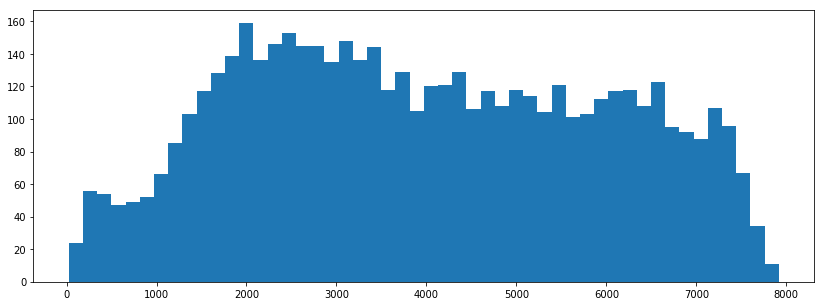

In [79]:
fig = plt.figure(figsize=(14,5))
ax = fig.gca()
plt.hist(docs_len, bins=50)
plt.show()

Maximum length will be 5,000

In [80]:
max_len = 5000

In [81]:
X_pad = pad_sequences(X_encoded, maxlen=max_len)
X_pad.shape

(5249, 5000)

In [82]:
# Scaling the data for the PCA
scaler = StandardScaler()
X_pad_scaled = scaler.fit_transform(X_pad)
X_pad_scaled

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.22754927, -0.22490599, -0.21028077, ..., -0.4000674 ,
        -0.39077817, -0.3001892 ],
       [-0.22754927, -0.22490599, -0.21028077, ..., -0.40639885,
        -0.39137499, -0.3001892 ],
       [ 0.93057391, -0.08839502, -0.11757473, ..., -0.19310791,
        -0.04462261, -0.00460124],
       ...,
       [-0.22754927, -0.22490599, -0.21028077, ..., -0.3458543 ,
        -0.34840396, -0.24228272],
       [-0.22754927, -0.22490599, -0.21028077, ..., -0.38819592,
         0.33913261, -0.3001892 ],
       [-0.22754927, -0.22490599, -0.21028077, ..., -0.38819592,
        -0.39137499,  1.77384664]])

In [83]:
# Transforming to PCA
pca_transformer = PCA(n_components=10).fit(X_pad_scaled)
X_pad_pca = pca_transformer.transform(X_pad_scaled)
X_pad_pca.shape

(5249, 10)

In [84]:
X_pad_pca[:3]

array([[-16.56648169,  -7.76639963,  -6.0240688 ,   1.35825797,
          0.24850964,   0.61655433,   0.47957601,   0.32119406,
          0.7334496 ,   0.57124989],
       [-12.51057352,  -1.64242384,  -4.35541161,   1.74490839,
         -0.07030225,   1.28807844,   0.04566294,   0.0588121 ,
          0.8347565 ,   0.31043283],
       [  2.9800015 ,  -7.39397236,  -2.13130296,   2.03659091,
         -0.07689446,   0.0307266 ,   0.77045608,   0.70583449,
          0.05159868,   0.45948009]])

In [85]:
X_pca_train = X_pad_pca[:len_train]
X_pca_test = X_pad_pca[len_train:]

In [86]:
joblib.dump(X_pca_test, "X_pca_test")
joblib.dump(X_pca_train, "X_pca_train")

['X_pca_train']

In [24]:
# X_pca_test = joblib.load("X_pca_test")
# X_pca_train = joblib.load("X_pca_train")

In [87]:
# I need these for the prediction of phase 3
X_pad_train = X_pad[:len_train]
X_pad_test = X_pad[len_train:]

# Phase 3 - Transfer Model

I used the following link to set the weights to the transfer model: https://github.com/keras-team/keras/issues/8860

In [88]:
from keras.engine.saving import preprocess_weights_for_loading

The model in this part does is not a classification model, but aims to generate a representation for each document, with witch one can classify, not necessary with deep learning.

In [89]:
# Calling the weights of the LSTM and embedding of the language model (the first model)
lstm_weights_m2 = preprocess_weights_for_loading(lstm_layer, weights_m1) # target layer, source weights
embedding_weights_m2 = preprocess_weights_for_loading(embedding_layer, weights_m1) 
dense_layer_m2 = preprocess_weights_for_loading(dense_layer, weights_m1) 

In [90]:
transfer_model = Sequential()
# On the next line originaly the input_din=vocab_size and input_length=CHUNK_SIZE-1, but I ran only part of the notebook
transfer_model.add(Embedding(input_dim=19693, output_dim=200,input_length=10))
transfer_model.add(SpatialDropout1D(0.2))
transfer_model.add(Bidirectional(LSTM(150, recurrent_dropout=0.35, return_sequences=True)))
transfer_model.add(MaxPooling1D(pool_size=3))
transfer_model.add(Flatten())
transfer_model.add(Dense(1500, activation='relu'))
adam = optimizers.Adam(lr=0.0002, decay=0, amsgrad=False)
transfer_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# This arethe lines that tell the model to use the weights of the language model into the lstm layer of this model. It must be
# after the compile, because the compile resets the weights


transfer_model.set_weights(embedding_weights_m2)
transfer_model.set_weights(lstm_weights_m2)
transfer_model.set_weights(dense_layer_m2)

In [91]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 200)           3938600   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 10, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 300)           421200    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 300)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1500)              1351500   
Total params: 5,711,300
Trainable params: 5,711,300
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Can see that the LSTM layer (for example) has the same weights as in the first model. Note that in the forst model the no. of
# layer is 3
lstm_weights_m2 = transfer_model.layers[2].get_weights()

In [95]:
# lstm_weights_m2

### Predict the test set

In [97]:
status_value_test = transfer_model.predict(X_pca_test)

In [98]:
status_value_test.shape

(822, 1500)

In [99]:
# Now the average is on the 'CHUNK_SIZE-1' dimension, because I want the LSTM vector per document
avg_vector_test = np.mean(status_value_test, axis=1)
avg_vector_test.shape

(822,)

### Predict the train set

In [100]:
status_value_train = transfer_model.predict(X_pca_train)

In [101]:
status_value_train.shape

(4427, 1500)

In [102]:
avg_vector_train = np.mean(status_value_train, axis=1)

In [103]:
avg_vector_train.shape

(4427,)

In [104]:
# Saving to file 
np.savetxt("status_value_test21.csv", status_value_test, delimiter=",")
np.savetxt("status_value_train21.csv", status_value_train, delimiter=",")